# Parsing HTML files containing users data

In [7]:
from bs4 import BeautifulSoup
from glob import glob
import json
from collections import defaultdict
import random
import json
from tqdm import tqdm

def looking_for(text):
    text = text.replace("& ", "")
    text = text.split("Looking for ")[-1]
    if " | " in text:        
        gender = text.split(" | ")[0].split(", ")
        relationship_type = text.split(" | ")[1].split(", ")
        return gender, relationship_type
    else:
        if "man" in text.lower():
            return text.split(", "), ""
        else:
            return "", text.split(", ")
        
with open("title2topic.json",'r') as f:
    title2topic = json.load(f)

basic_values = {
    "name": ("profile-basics-username-text", "cardsummary-item cardsummary-realname"),
    "age": ("profile-basics-asl-age", "cardsummary-item cardsummary-age"),
    "location": ("profile-basics-asl-location", "cardsummary-item cardsummary-location")
}

essays_class = ("profile-essay", "qmessays-essay")
image_class = ("profile-thumb", "qmcard-carousel-viewport-inner")

users = glob("users/*.html")
random.shuffle(users)

users_basics = []

for user in tqdm(users):
    with open(user,'r') as f:
        data = f.read()
    basics = {}

    user_id = user[6:-5]
    soup = BeautifulSoup(data)

    r = soup.find("span",{"class":"profile-basics-username-text"})

    if r:
        index = 0
    else:
        index = 1

    for name, value in basic_values.items():
        basics[name] = soup.find("span",{"class": value[index]}).text
    basics["age"] = int(basics["age"])

    basics = {}
    values = [v.text for v in soup.find_all("div", {"class": "matchprofile-details-text"})]
    
    first = 0
    for term in ["VACCINATED"]:
        if term in values[first]:
            first += 1

    sexual_basics = values[first].split(" | ")
    
    if len(sexual_basics) == 3:
        gender, sexual_orientation, relationship_type = sexual_basics
    elif len(sexual_basics) == 4:
        gender, sexual_orientation, bdsm, relationship_type = sexual_basics
    elif len(sexual_basics) == 2:
        gender, relationship_type = sexual_basics
        relationship_type = ""
    else:
        print(values[0])
        continue

    lf_gender, lf_relationship_type = looking_for(values[-1])
    basics["user_id"] = user_id
    basics["gender"] = gender
    basics["sexual_orientation"] = sexual_orientation
    basics["relationship_type"] = relationship_type
    basics["looking_for_gender"] = lf_gender
    basics["looking_for_relationship_type"] = lf_relationship_type
    basics["extra"] = " | ".join(values[first:-1])
    users_basics.append(basics)

100%|██████████| 21628/21628 [02:31<00:00, 142.31it/s]


In [ ]:
import pandas as pd
df = pd.DataFrame(users_basics)
df.head()

In [ ]:
import pandas as pd

essays = []
for answer in soup.find_all("div", {"class": essays_class[index]}):
    if index == 1:
        try:
            title = answer.find("h2").text
        except:
            continue
        topic = title2topic[title]
    else:
        try:
            topic, title = [t.text for t in answer.find_all("h2")]
        except:
            continue

    essays.append( {"user_id": user_id, "topic": topic, "title": title, "answer": answer.find("p").text.strip()} )

essays = pd.DataFrame(essays)
essays.head()

<AxesSubplot:xlabel='age'>

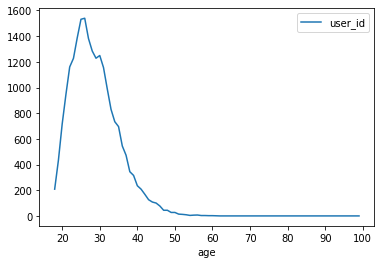

In [461]:
df[["age","user_id"]].groupby("age").count().plot()

# Parsing JSON files containing users answers

In [11]:
from tqdm import tqdm
expected_answers = []
personal_answers = []

question2id = {}

for user in tqdm(users):
    user_id = user[6:-5]

    with open(f"answers/{user_id}.json",'r') as f:
        data = f.read()

    try:
        questions = json.loads(data)
    except:
        continue

    for question in questions:
        importance = question["target"]["importance"]
        accepts = question["target"]["accepts"]
        answer = question["target"]["answer"]

        question_id = question["question"]["id"]

        personal_answer = {
            "user_id": user_id,
            "question_id": question_id,
            "answer": answer,
            "importance": importance
        }
        
        personal_answers.append(personal_answer)

        question2id[question["question"]["text"]] = question_id
        for accept in accepts:
            next_answer = {
                "user_id": user_id,
                "question_id": question_id,
                "accepts": accept,
                "importance": importance
            }
            
            expected_answers.append(next_answer)

expected_answers = pd.DataFrame(expected_answers)
personal_answers = pd.DataFrame(personal_answers)

100%|██████████| 21628/21628 [00:53<00:00, 407.71it/s]


In [486]:
[(text, question_id) for text, question_id in question2id.items() if "smok" in text]

[('Could you be in a committed relationship with someone who regularly smokes pot (> 2 times a week)?',
  462356),
 ('Have you smoked a cigarette in the last 6 months?', 501),
 ('Regardless of whether or not you smoke marijuana, do you think it should be legalized for adults?',
  341),
 ('Would you go out with a smoker?', 13006),
 ('You witness your next door neighbors discreetly smoking marijuana on their own property.  How do you respond?',
  47589),
 ('What do you think of laws that make smoking illegal in bars and restaurants?',
  13054),
 ('How often do you smoke cigars?', 80621),
 ('Do you smoke Weed?', 119507),
 ('If you had a potentially harmful addiction such as smoking, drinking, or drugs, how do you think you would you feel if a significant other tried to get you to stop?',
  36331),
 ('Do you think parents who smoke in cars with very young children should be punished?',
  51053),
 ('If you caught your child smoking pot what would you do?', 21487),
 ('Do you think it is acce

In [ ]:
personal_answers[personal_answers["question_id"] == 462356][["answer","user_id"]]

# Testing stuff

## Search users by keyword

In [1]:
from users_by_question import keyword_search
keyword_search("420")